## Notebook documenting functionality of models developed in [Shastry and Berg 2024](https://doi.org/10.1101/2024.08.06.606888) 

Running these functions requires the following dependencies:
- moments ([https://bioconda.github.io/recipes/moments/README.html](https://bioconda.github.io/recipes/moments/README.html)) 
- numpy
- itertools
- scipy
- matplotlib

In [138]:
# numerics + rv stuff
import numpy as np
from numpy.random import default_rng
import scipy as sp
import itertools as it

import moments

# plotting + misc tools
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import os

# method of moments framework + helper functions
from mom_functions import *

# rng setup
rng = default_rng(82020)

# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["figure.figsize"] = [5, 3.5]
plt.rcParams["figure.dpi"] = 110
plt.rcParams["axes.axisbelow"] = True
plt.rcParams.update({"figure.facecolor": "white"})

### Introducing the age conditioned SFS (acSFS)

In standard notation, the expected SFS is given by $\Phi_{2n}$ for a diploid sample of size $n$. This quantity is, typically, of size $2n+1$, where the $0^{th}$ and $2n^{th}$ entries represent the lost and fixed bins, respectively. 

The acSFS represents the expected number of sites present at sample frequency $i$, conditional on having arisen $a$ generations ago. For a diploid sample of size $n$, we denote acSFS in the present-day (generation $0$) for alleles that arose $a$ generation ago as $\Phi^{0\mid a}_{2n}$. Thus, $\Phi^{0\mid a}_{2n}(i)$ gives the expected number of alleles $a$ generations old that are found at frequency $i$ in a diploid sample of size $n$. Below, in code, we use a matrix that contains a stack of these acSFS for easy indexing and storage, so this quantity is of size $T_{\mathrm{max}} \times (2n+1)$, where $T_{\mathrm{max}}$ is the largest number of generations we run the algorithm to. In this matrix, the $a^{th}$ row consists of the acSFS for alleles that are $a$ generations old. 

Below is code on how to compute the acSFS for a given constant population size $(N=10,000)$, population scaled selection coefficient $(\gamma = -10\ \mathrm{or}\  s = -1\times 10^{-3})$ across $100,000$ generations with a constant population scaled mutation rate $(\theta=200)$. 

As a check, a scatter plot showing that the acSFS marginalized across all generations from $1$ to some large $T_{\mathrm{max}}$ yields the equilbirium SFS from $\texttt{moments}$, as expected (Equation S1)
$$
\Phi^{0}_{2n}[i]=\sum_{a=1}^{T_{\mathrm{max}}}\Phi^{0\mid a}_{2n}[i]
$$

(30000, 201)


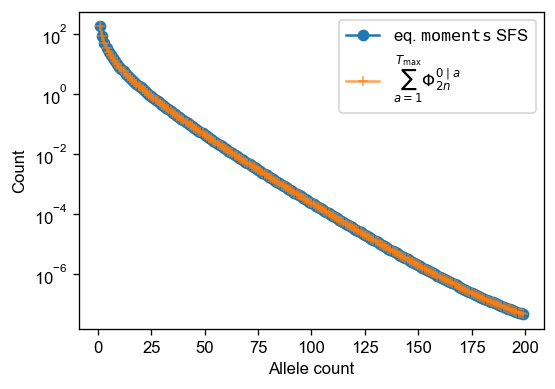

In [139]:
## simulation parameters
N = 10000
gamma = -10
theta = 200

## sample size
twon = 200 

## computing the equilibrium SFS under the population parameters using moments
sfs = moments.Spectrum(moments.LinearSystem_1D.steady_state_1D(2000, gamma=gamma, theta=theta))
sfs = sfs.project([twon])

## computing the stack of acSFS for the same population parameters
## (we invert the acSFS for easy indexing, so row $a$ contains the acSFS for alleles that are $a$ generations old)
acsfs = run_mom_iterate_constant(Amax=30000, twon=twon, s=gamma/N, N=N, theta=theta)[::-1]
print(acsfs.shape)

## showing that the sum of the acSFS across all generations yields the equilibrium SFS from moments
plt.figure(dpi=120)
plt.plot(range(1,twon), sfs[1:-1], '-o', linewidth=1.5, label=r'eq. $\tt{moments}$ SFS'); plt.semilogy(); plt.xlabel('Allele count'); plt.ylabel('Count')
plt.plot(range(1,twon), acsfs.sum(axis=0)[1:-1], '-+', linewidth=1.5, alpha=0.7, label=r'$\sum_{a=1}^{T_\mathrm{max}} \Phi^{0\mid a}_{2n}$'); plt.legend(); 

### Visualizing the acSFS

We can now visualize and summarize properties of the acSFS below:
- $P(a \mid \gamma, n)$ which is the probability density on age conditional on a particular selection coefficient and sample size (i.e., conditional on segregation)
- $P(a \mid i, \gamma, n)$ which is the probability density on age conditional on a segregating sample count $i$ (sample frequency, $\frac{i}{2n}$) in the present

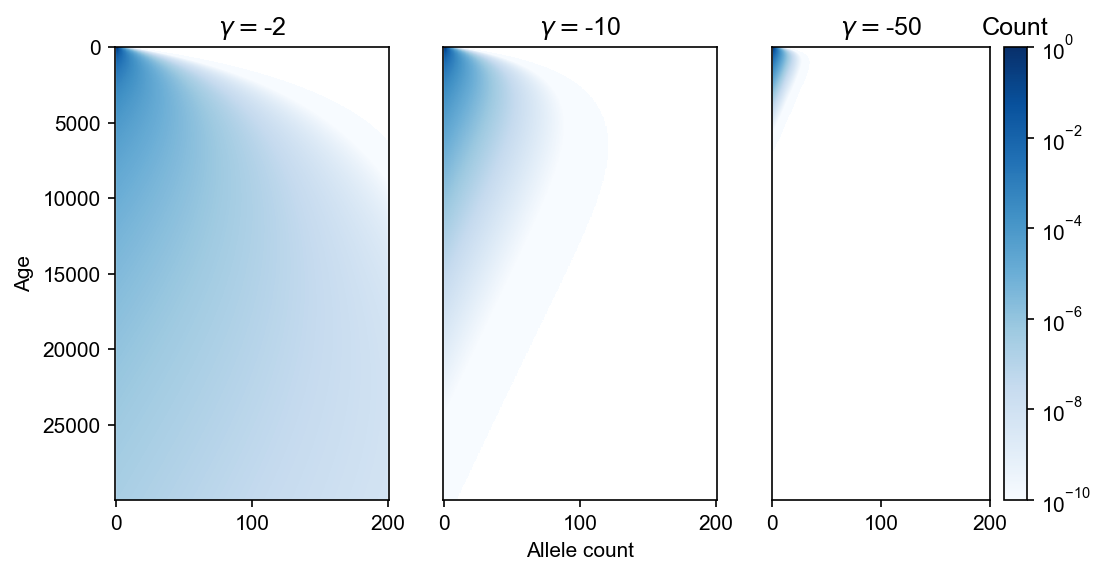

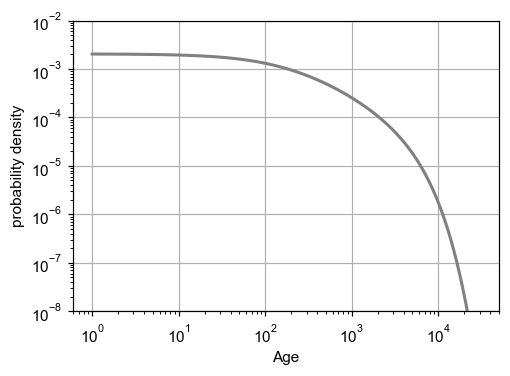

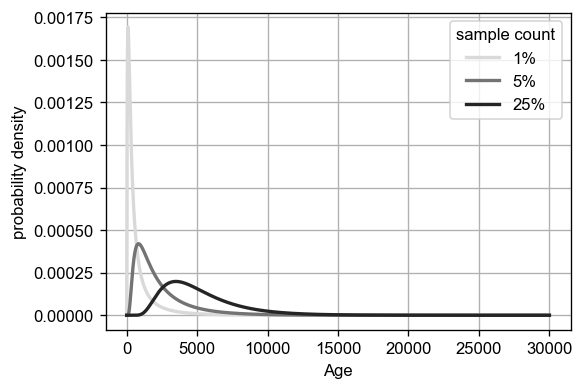

In [140]:
## visualizing the stack of acSFS
## showing three different gamma values [0.2 x gamma, gamma, 5 x gamma]
plt.figure(figsize=(8,4),dpi=150)
plt.subplot(1,3,1)
acsfs2 = run_mom_iterate_constant(Amax=30000, twon=twon, s=0.2*gamma/N, N=N, theta=theta)[::-1]
plt.imshow(acsfs2, cmap='Blues', aspect='auto', norm=colors.LogNorm(vmin=1e-10)); 
plt.ylabel(r'Age'); plt.title(r'$\gamma=${:d}'.format(int(0.2*gamma)))

plt.subplot(1,3,2)
plt.imshow(acsfs, cmap='Blues', aspect='auto', norm=colors.LogNorm(vmin=1e-10)); plt.yticks([])
plt.xlabel('Allele count'); plt.title(r'$\gamma=${:d}'.format(gamma))

plt.subplot(1,3,3)
acsfs3 = run_mom_iterate_constant(Amax=30000, twon=twon, s=5*gamma/N, N=N, theta=theta)[::-1]
plt.imshow(acsfs3, cmap='Blues', aspect='auto', norm=colors.LogNorm(vmin=1e-10)); plt.yticks([]); cbar = plt.colorbar(); cbar.ax.set_title('Count') 
plt.title(r'$\gamma=${:d}'.format(int(5*gamma))); plt.show()

## visualizing the distribution on age conditional on segregation
plt.plot(range(1,acsfs.shape[0]+1), acsfs.sum(axis=1)/acsfs.sum(), color='grey', linewidth=2); plt.xlabel('Age'); plt.ylabel('probability density')
plt.loglog(); plt.ylim((1e-8, 1e-2)); plt.grid(); plt.show()

## sample frequency of 1%, 5%, 25%
i = [0.01, 0.05, 0.25]
gcols = ['#d9d9d9','#737373','#252525']
plt.figure(dpi=120)
for idx, i in enumerate(i):
    plt.plot(range(1,acsfs.shape[0]+1), acsfs[:,int(i*twon)]/acsfs[:,int(i*twon)].sum(), linewidth=2, color=gcols[idx], label='{:d}%'.format(int(i*100)))
plt.xlabel('Age'); plt.ylabel('probability density'); plt.legend(title='sample count'); plt.grid()

## Changing population sizes

The methodology is similar for changing population sizes, except we now have a vector of population sizes across all generations to $T_{\mathrm{max}}$, such that the $t^{th}$ index is the population size in generation $t$. 

For instance, I demonstrate this with a truncated version (only going back $T_{\mathrm{max}} \approx 30,000$ generations for speed) of a demography inferred from the UK 10K data set. Similarly, we show the correspondence between the two quantities as in the constant sized case above.  

**NOTE**: if you're using a weaker selection coefficient, then you will need to increase $T_{\mathrm{max}} > 50,000$ generations (by changing the first epoch in the _demo.txt_ file) if you want to see a one-to-one correspondence with $\texttt{moments}$. This is to ensure that the SFS reaches equilibrium. 

Text(0.5, 1.0, 'UK 10K demographic history')

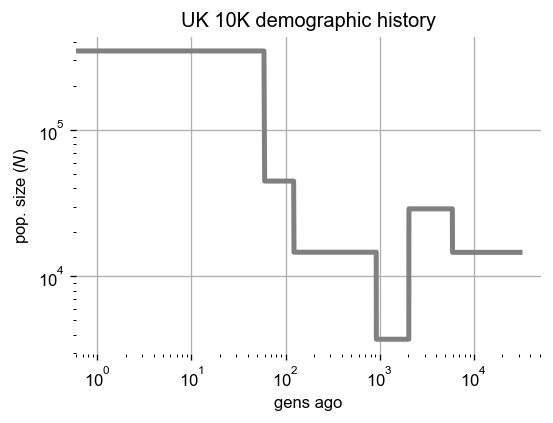

In [141]:
## demoraphic file with # of row = total # of epochs with the column 1 : pop size (diploid inds), column 2 : # of generations 
## (using same notation as PReFerSim)
demo = np.loadtxt("PReFerSims/simfiles/UK10K_demo.txt", delimiter=" ", dtype='int')

## expanding it out to a vector of population sizes & plotting
Nc = []
[Nc.append([demo[n,0]]*demo[n,1]) for n in np.arange(len(demo))]
Nc = np.array(list(it.chain(*Nc))); Nc = Nc[::-1]

plt.figure(dpi=120)
plt.plot(Nc,linewidth=3,color='grey'); plt.grid(); plt.box(False); 
plt.loglog(); plt.xlabel('gens ago'); plt.ylabel(r'pop. size ($N$)'); plt.title('UK 10K demographic history')

Constructing probability transition matrices for each epoch...done!
 Starting SFAS construction: 
20%...40%...60%...80%...done!
CPU times: user 1min 44s, sys: 8.8 s, total: 1min 53s
Wall time: 15.9 s


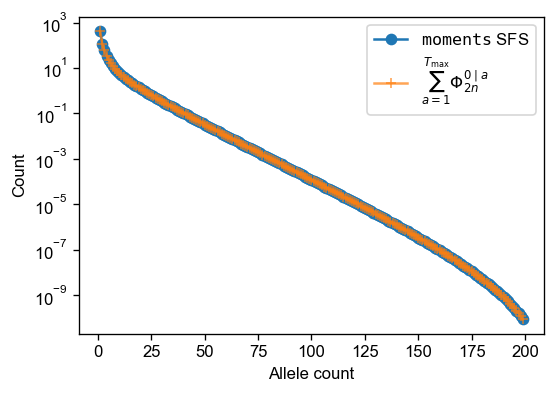

In [146]:
## simulation parameters
twon = 200
theta = 400
gamma = -20

## computing the moments SFS
sfs_UK10K = moments.Spectrum(moments.LinearSystem_1D.steady_state_1D(2000,gamma=gamma))*theta
## iterating the SFS epoch-by-epoch
for i in range(0,len(demo)): 
    sfs_UK10K.integrate([demo[i,0]/demo[0,0]], demo[i,1]/(2*demo[0,0]), gamma=gamma, dt_fac=1e-3, theta=theta)
sfs_UK10K = sfs_UK10K.project([200])

## comuting the stack of acSFS (note the different function than the constant sized case)
%time acsfs_UK10K = run_mom_iterate_changing5(twon=twon, s=gamma/demo[0,0], Nc=Nc, theta=theta) 

## plotting the correspondence
plt.figure(dpi=120)
plt.plot(range(1,twon), sfs_UK10K[1:-1], '-o', linewidth=1.5, label=r'$\tt{moments}$ SFS'); 
plt.plot(range(1,twon), acsfs_UK10K.sum(axis=0)[1:-1], '-+', linewidth=1.5, alpha=0.7, label=r'$\sum_{a=1}^{T_\mathrm{max}} \Phi^{0\mid a}_{2n}$'); 
plt.semilogy(); plt.xlabel('Allele count'); plt.ylabel('Count'); plt.legend(); 